# Load the required libraries

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime as dt
import re

import pprint
pp = pprint.PrettyPrinter(indent=4)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# To Plot matplotlib figures inline on the notebook
%matplotlib inline

#plt.style.use('fivethirtyeight') # pretty matplotlib plots
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (9, 5)
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.gofplots import ProbPlot

import scipy.stats as stats

from sklearn.linear_model import Lasso, Ridge, LinearRegression, lars_path
from sklearn.model_selection import (cross_val_score, train_test_split, 
                                     KFold, GridSearchCV)
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, Normalizer, RobustScaler

/Users/sakina/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# read in the scraped data

In [3]:
project_df = pd.read_pickle('KickstarterScrapeDataBS_final.txt')

In [4]:
project_df.shape

(35520, 25)

### Clean the rewards_tier and backers_tier columns

In [4]:
proj_rewards = []
proj_backers = []
for rewards, backers in zip(project_df['rewards_tier'], project_df['backers_tier']):
    rewards_list = [int(r) for r in rewards]
    backers_list = [int(b.replace(',','')) for b in backers]
    
    proj_rewards.append(rewards_list)
    proj_backers.append(backers_list)    

In [5]:
project_df['rewards_tier'] = proj_rewards 
project_df['backers_tier'] = proj_backers 

### Create rewards count, min and max columns

In [6]:
rewards_cnt = []
rewards_min = []
rewards_max = []
for rewards in project_df['rewards_tier']:  
    if rewards:
        rewards_cnt.append(len(rewards))
        rewards_min.append(min(rewards)) 
        rewards_max.append(max(rewards))
    else:
        rewards_cnt.append(0)
        rewards_min.append(0) 
        rewards_max.append(0)

In [7]:
project_df['rewards_count'] = rewards_cnt 
project_df['rewards_min'] = rewards_min
project_df['rewards_max'] = rewards_max

### Get word count of blurb and title

In [8]:
title_wordcnt = []
for title in project_df['project_name']:
    title_wordcnt.append(len(re.findall("(\S+)", title)))

In [9]:
blurb_wordcnt = []
for blurb in project_df['blurb']:
    blurb_wordcnt.append(len(re.findall("(\S+)", blurb)))

In [10]:
project_df['title_wordcnt'] = title_wordcnt
project_df['blurb_wordcnt'] = blurb_wordcnt

### Consider only successful and failed projects

In [12]:
project_df['project_status'].value_counts()

successful    32564
failed         2681
live            275
Name: project_status, dtype: int64

In [11]:
project_df = project_df[project_df['project_status']!='live']
project_df.shape

(35245, 30)

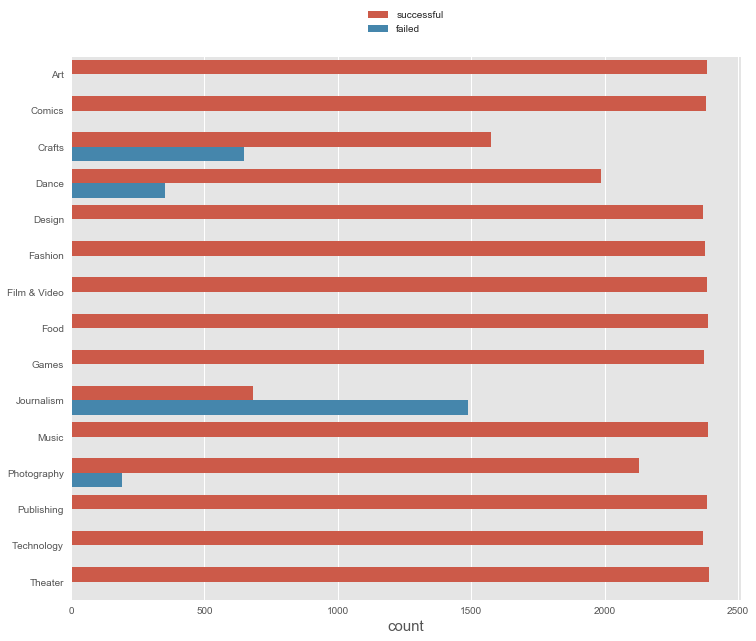

In [14]:
fig = plt.figure(figsize=(12,10));
sns.countplot(y='category',hue='project_status', data=project_df);
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1));
plt.ylabel('');
fig.savefig('ProjectPortfolio.png', bbox_inches='tight')

### Extract the project's launch date's quarter and month

In [12]:
project_df['launch_quarter'] = project_df['launched_at'].dt.quarter
project_df['launch_month'] = project_df['launched_at'].dt.month

### Recompute percent_funded column

In [16]:
project_df.loc[:,'percent_funded'] = np.around(100*
            project_df.loc[:,'pledged_amount']/project_df.loc[:,'goal_amount'], 2)
project_df['percent_funded'].describe()

count    3.524500e+04
mean     1.583443e+03
std      8.277957e+04
min      0.000000e+00
25%      1.040000e+02
50%      1.181600e+02
75%      2.008800e+02
max      1.042779e+07
Name: percent_funded, dtype: float64

In [17]:
project_df['category'].loc[project_df['percent_funded'].idxmax()]

'Music'

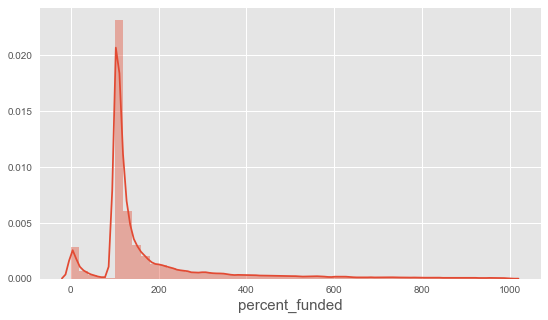

In [18]:
sns.distplot(project_df[project_df['percent_funded']<1000]['percent_funded']);

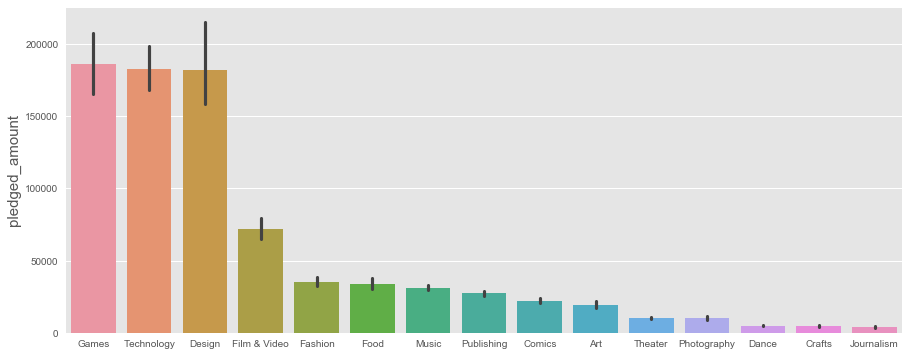

In [19]:
fig = plt.figure(figsize=(15,6));
result = project_df.groupby(["category"])['pledged_amount'].aggregate('sum').reset_index().\
                            sort_values('pledged_amount', ascending=False)
sns.barplot(x='category',y='pledged_amount',data=project_df, #[project_df['category']!='Music'],
            order=result['category']);
plt.xlabel('');
fig.savefig('PledgeCategory.png', bbox_inches='tight')

### Take log trasform of pledged amount, goal amount and rewards count

In [13]:
project_df['pledged_log'] = project_df['pledged_amount'].apply(lambda x : np.log(x))
project_df['goal_log'] = project_df['goal_amount'].apply(lambda x : np.log(x))
project_df['rewards_log'] = project_df['rewards_count'].apply(lambda x : np.log(x) if x>0 else -5)

In [22]:
pp.pprint(project_df.columns)

Index(['category', 'subcategory', 'project_id', 'project_name', 'blurb',
       'goal_amount', 'pledged_amount', 'percent_funded', 'currency',
       'fx_rate', 'project_status', 'location', 'city', 'state', 'country',
       'state_changed_at', 'created_at', 'launched_at', 'deadline', 'backers',
       'project_url', 'rewards_url', 'duration', 'rewards_tier',
       'backers_tier', 'rewards_count', 'rewards_min', 'rewards_max',
       'title_wordcnt', 'blurb_wordcnt', 'launch_quarter', 'launch_month',
       'pledged_log', 'goal_log', 'rewards_log'],
      dtype='object')


# Linear Regression Models

### Some helper functions

In [23]:
def diagnostic_plot(x, y, rgr):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,8))
    fig.suptitle('Diagnostic Plots')
    
    pred = rgr.predict(x)
    res = y - pred
    
    sns.regplot(y, pred, color='blue',
                scatter_kws={'alpha': 0.2}, 
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
                ax=ax1)
    ax1.set_xlabel('Actual Value');
    ax1.set_ylabel('Predicted Value');
    ax1.set_title('Target Variable');
    
    sns.residplot(pred, y, lowess=True, color='blue', 
                  scatter_kws={'alpha': 0.2}, 
                  line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
                  ax=ax2)
    ax2.set_title("Residual plot")
    ax2.set_xlabel("Predicted Value")
    ax2.set_ylabel("Residuals")
    
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution     
    QQ = ProbPlot(res)
    QQ.qqplot(line='45', alpha=0.2, color='#4C72B0', lw=1,
              xlabel='Theoretical Quantiles',
              ylabel='Residuals', ax=ax3)
    ax3.set_title("Normal Q-Q plot")
    ax3.axis('equal')

    return fig

In [24]:
def build_grid_search_est(model, X, y, cv=5, **params):
    
    grid_est = GridSearchCV(model, param_grid=params, cv=cv)
    grid_est.fit(X, y)
    df = pd.DataFrame(grid_est.grid_scores_)
    for param in params:
        df[param] = df.parameters.apply(lambda val: val[param])
        plt.semilogx(df.alpha, df.mean_validation_score)
        plt.xlabel('log(alpha)')
        plt.ylabel('mean_validation_score')
    grid_est.grid_scores_
    return grid_est

In [25]:
def RMSE(actual, predicted):
    return np.sqrt(mean_squared_error(actual,predicted))

In [74]:
def add_square_terms(df, sel_columns):    
    
    df_poly = df.copy()
    
    if not sel_columns:
        sel_columns=df_poly.columns
        
    for c in sel_columns:
        df_poly[c + '**2'] = df[c]**2
        
    return df_poly

### Build a CV and Hold Out Set to test different Models

In [14]:
all_feature_cols = ['category', 'goal_amount', 'goal_log', 'duration', 'rewards_count', 'rewards_log',
                    'rewards_min', 'rewards_max', 'title_wordcnt', 'blurb_wordcnt', 'state',
                    'launch_quarter', 'launch_month', 'project_status']
all_target_cols = ['pledged_amount', 'pledged_log']

X_all, y_all = project_df[all_feature_cols], project_df[all_target_cols]

X_train_all, X_holdout_all, y_train_all, y_holdout_all = train_test_split(X_all, y_all, test_size=0.2, random_state=0)

In [28]:
pp.pprint((X_train_all.shape, X_holdout_all.shape))

((28196, 14), (7049, 14))


### Split Training Data into Multiple Folds

In [15]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

# Model 1 - using raw goal and pledged amounts

In [29]:
feature_col = ['category', 'goal_amount', 'duration', 'rewards_count']
target_col = ['pledged_amount']

project_sel_df2 = X_train_all[feature_col].join(y_train_all[target_col])
pp.pprint((project_sel_df2.columns, project_sel_df2.shape))

(   Index(['category', 'goal_amount', 'duration', 'rewards_count',
       'pledged_amount'],
      dtype='object'),
    (28196, 5))


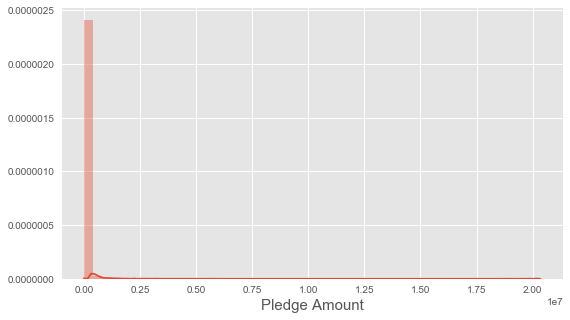

In [174]:
sns_plot = sns.distplot(project_sel_df2['pledged_amount']);
sns_plot.set_xlabel("Pledge Amount");
#sns_plot.get_yaxis().get_major_formatter().set_scientific(True)
plt.ticklabel_format(style='scientific', axis='y', useOffset=False)
fig = sns_plot.get_figure()
fig.savefig('PledgeDistributionOriginal.png', bbox_inches='tight');

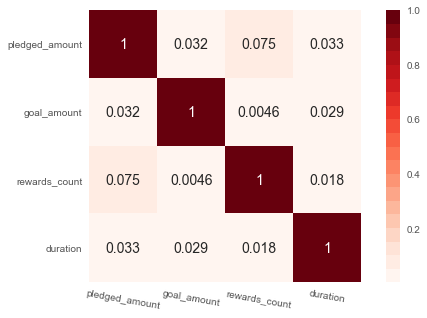

In [164]:
sns_plot = sns.heatmap(project_sel_df2[['pledged_amount', 'goal_amount', 'rewards_count', 'duration']].corr(),annot=True,square=True, 
                      cmap=plt.cm.get_cmap('Reds', 20));
plt.yticks(rotation=0) 
plt.xticks(rotation=-10) 
fig = sns_plot.get_figure()
fig.savefig('CorrMatrixOriginal.png', bbox_inches='tight');

In [31]:
category_dummy = pd.get_dummies(project_sel_df2['category'])
project_sel_df2 = project_sel_df2.join(category_dummy)
project_sel_df2.drop(['category', 'Theater'], inplace=True, axis=1)

In [32]:
X_train, y_train = project_sel_df2.drop('pledged_amount',axis=1), project_sel_df2['pledged_amount']

In [33]:
lr_model2 = sm.OLS(y_train,sm.add_constant(X_train))
results = lr_model2.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         pledged_amount   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     143.0
Date:                Sun, 04 Feb 2018   Prob (F-statistic):               0.00
Time:                        14:49:38   Log-Likelihood:            -3.8650e+05
No. Observations:               28196   AIC:                         7.730e+05
Df Residuals:                   28178   BIC:                         7.732e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.412e+04   6519.690     -2.166      0.030   -2.69e+04   -1345.333
goal_amount       0.0103      0.002      4.925      0.000       0.006       0.014
duration        286.6720    121.102      2.367      0.018      49.307     524.037
rewards_count  1657.3397    173.585      9.548      0.000    1317.104    1997.575
Art            3501.4693   7036.748      0.498      0.619   -1.03e+04    1.73e+04
Comics         -486.0914   7108.439     -0.068      0.945   -1.44e+04    1.34e+04
Crafts        -6988.1806   7126.500     -0.981      0.327    -2.1e+04    6980.103
Dance         -2204.7982   7037.978     -0.313      0.754    -1.6e+04    1.16e+04
Design          1.41e+05   7057.334     19.981      0.000    1.27e+05    1.55e+05
Fashion        1.903e+04   7024.258      2.709      0.007    5259.191    3.28e+04
Film & Video   4.601e+04   7145.873      6.439      0.000     3.2e+04       6e+04
Food           1.581e+04   7022.774      2.251      0.024    2046.544    2.96e+04
Games          1.592e+05   7042.114     22.603      0.000    1.45e+05    1.73e+05
Journalism    -2835.2788   7198.833     -0.394      0.694   -1.69e+04    1.13e+04
Music          9135.3428   7115.260      1.284      0.199   -4810.910    2.31e+04
Photography     385.3441   7032.325      0.055      0.956   -1.34e+04    1.42e+04
Publishing     1.071e+04   7055.890      1.518      0.129   -3117.121    2.45e+04
Technology     1.684e+05   7057.201     23.864      0.000    1.55e+05    1.82e+05
==============================================================================
Omnibus:                    80697.998   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       9607643154.217
Skew:                          38.257   Prob(JB):                         0.00
Kurtosis:                    2861.675   Cond. No.                     9.47e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.47e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [35]:
# Standardize the training feature set
X_train_std = RobustScaler().fit_transform(X_train)

lr_base2_std = LinearRegression();

scores = cross_val_score(lr_base2_std, X_train_std, y_train, cv=kfold)
print('Baseline Linear Regression Cross validation - Model 1')
print('scores: ', scores)
print("Mean Score: ", np.mean(scores))

# Build the Model
lr_base2_std.fit(X_train_std, y_train)

Baseline Linear Regression Cross validation - Model 1
scores:  [ 0.09461041  0.1195668   0.11648181 -1.18851651  0.09732598]
Mean Score:  -0.152106299986


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

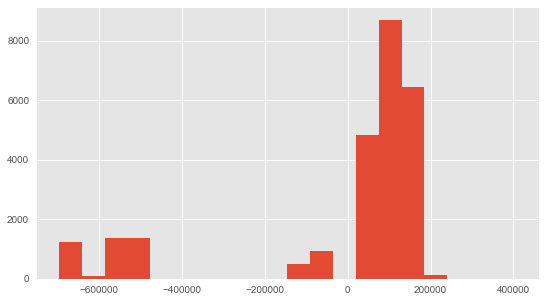

In [176]:
plt.hist(y_train-lr_base2_std.predict(X_train_std), bins=20);

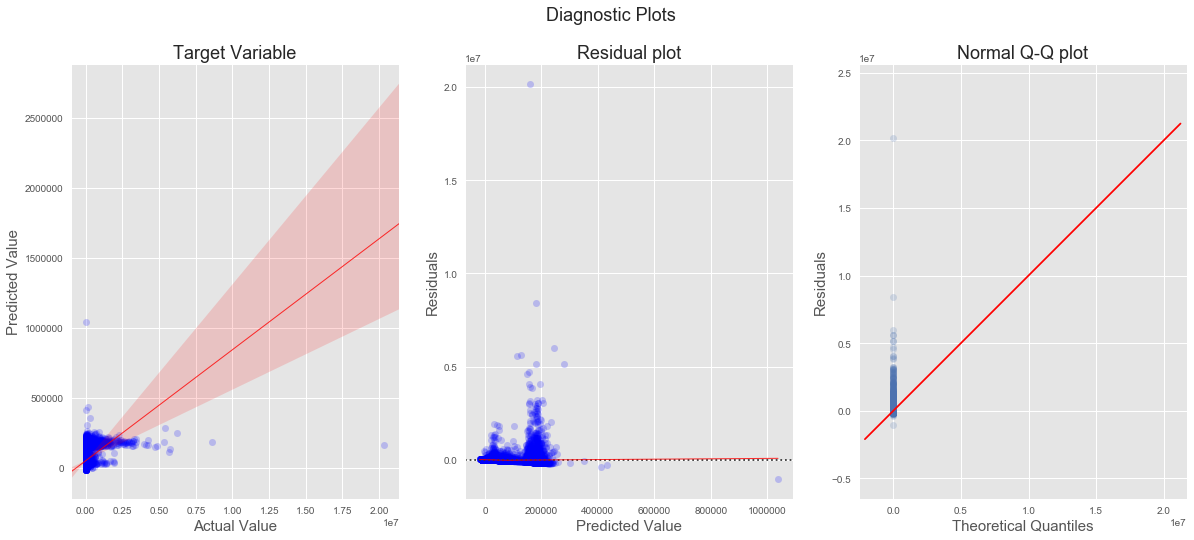

In [36]:
fig = diagnostic_plot(X_train_std, y_train, lr_base2_std)

Lasso Grid Search


/Users/sakina/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/sakina/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Lasso Best Scores -0.152097551192


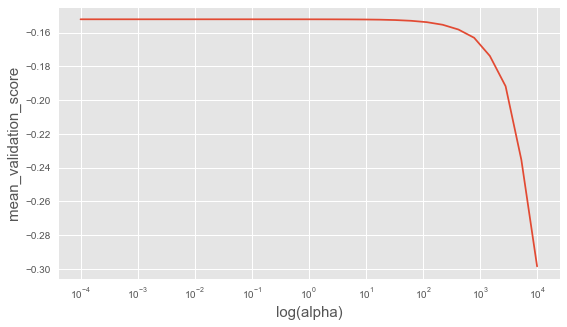

In [37]:
print("Lasso Grid Search")
lasso_grid_est = build_grid_search_est(Lasso(), X_train_std, y_train, cv=kfold,
                                       alpha=np.logspace(-4, 4, 30))
print("Lasso Best Scores", lasso_grid_est.best_score_)

Ridge Grid Search


/Users/sakina/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/sakina/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Ridge Best Scores -0.152097557465


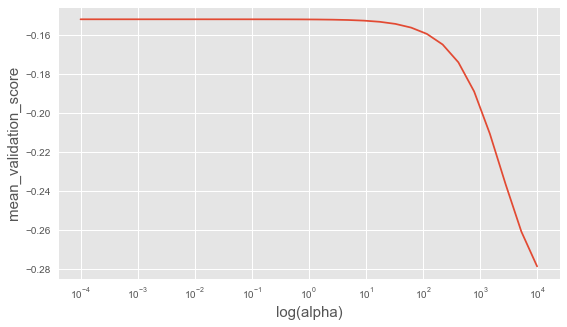

In [38]:
print("Ridge Grid Search")
ridge_grid_est = build_grid_search_est(Ridge(), X_train_std, y_train, cv=kfold,
                                       alpha=np.logspace(-4, 4, 30))
print("Ridge Best Scores", ridge_grid_est.best_score_)

# Model 2 - Discarding outliers from goal amount and pledged amount

In [39]:
feature_col = ['category', 'goal_amount', 'duration', 'rewards_count']
target_col = ['pledged_amount']

project_sel_df3 = X_train_all[feature_col].join(y_train_all[target_col])
(project_sel_df3.columns, project_sel_df3.shape)

(Index(['category', 'goal_amount', 'duration', 'rewards_count',
        'pledged_amount'],
       dtype='object'), (28196, 5))

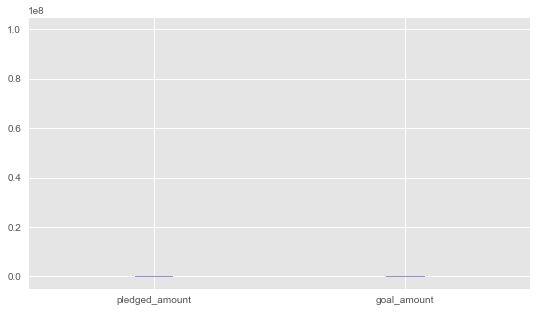

In [41]:
project_sel_df3.boxplot(column=['pledged_amount', 'goal_amount']);

In [42]:
# remove outliers from pledged_amount
threshold = project_sel_df3['pledged_amount'].quantile(.95)
project_sel_df3 = project_sel_df3[project_sel_df3['pledged_amount']<=threshold]
project_sel_df3.shape

(26786, 5)

In [43]:
# remove outliers from goal_amount
threshold = project_sel_df3['goal_amount'].quantile(.95)
project_sel_df3 = project_sel_df3[project_sel_df3['goal_amount']<=threshold]
project_sel_df3.shape

(25583, 5)

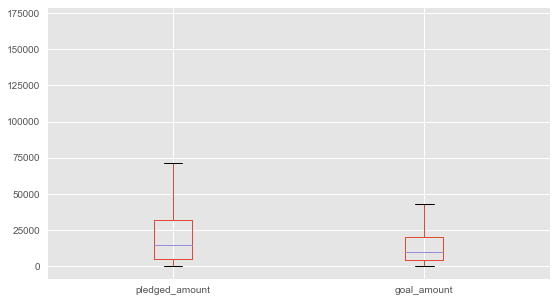

In [44]:
project_sel_df3.boxplot(column=['pledged_amount', 'goal_amount']);

In [45]:
(project_sel_df3['pledged_amount'].max(), project_sel_df3['goal_amount'].max())

(170509.0, 50000.0)

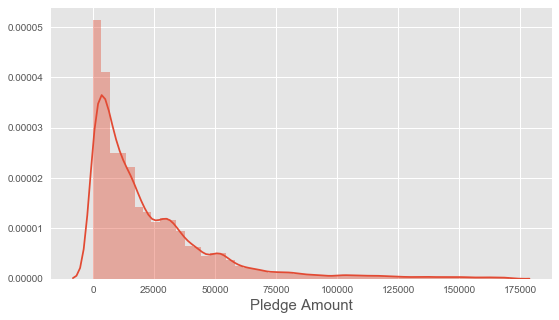

In [46]:
sns_plot = sns.distplot(project_sel_df3['pledged_amount']);
sns_plot.set_xlabel("Pledge Amount");
fig = sns_plot.get_figure()
fig.savefig('PledgeDistributionNoOutliers.png', bbox_inches='tight');

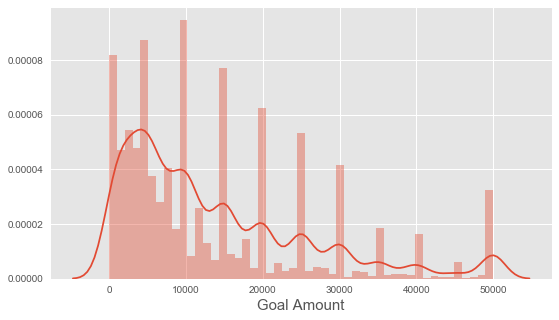

In [47]:
sns_plot = sns.distplot(project_sel_df3['goal_amount']);
sns_plot.set_xlabel("Goal Amount");

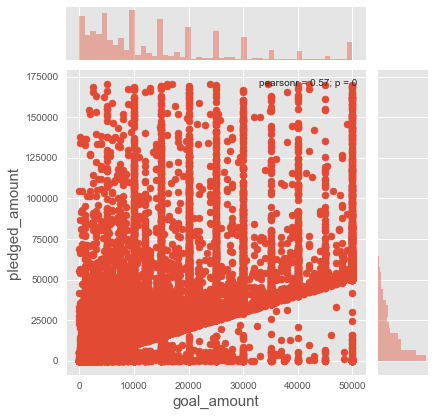

In [50]:
sns.jointplot('goal_amount','pledged_amount',project_sel_df3);

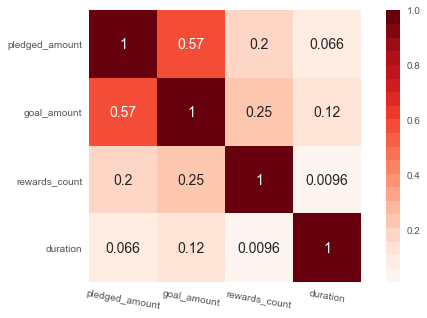

In [158]:
sns_plot = sns.heatmap(project_sel_df3[['pledged_amount', 'goal_amount', 'rewards_count', 'duration']].corr(),annot=True,square=True, 
                       cmap=plt.cm.get_cmap('Reds', 20));
plt.yticks(rotation=0) 
plt.xticks(rotation=-10) 
fig = sns_plot.get_figure()
fig.savefig('CorrMatrixNoOutliers.png', bbox_inches='tight');

In [152]:
fig.axes[0]

In [52]:
category_dummy = pd.get_dummies(project_sel_df3['category'])
project_sel_df3 = project_sel_df3.join(category_dummy)
project_sel_df3.drop(['category', 'Theater'], inplace=True, axis=1)
project_sel_df3.columns

Index(['goal_amount', 'duration', 'rewards_count', 'pledged_amount', 'Art',
       'Comics', 'Crafts', 'Dance', 'Design', 'Fashion', 'Film & Video',
       'Food', 'Games', 'Journalism', 'Music', 'Photography', 'Publishing',
       'Technology'],
      dtype='object')

In [53]:
X_train, y_train = project_sel_df3.drop('pledged_amount',axis=1), project_sel_df3['pledged_amount']

In [54]:
lr_model3 = sm.OLS(y_train,sm.add_constant(X_train))
results = lr_model3.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         pledged_amount   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     1980.
Date:                Sun, 04 Feb 2018   Prob (F-statistic):               0.00
Time:                        15:00:57   Log-Likelihood:            -2.8681e+05
No. Observations:               25583   AIC:                         5.737e+05
Df Residuals:                   25565   BIC:                         5.738e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1304.1930    552.647      2.360      0.018     220.974    2387.412
goal_amount       0.7870      0.012     67.814      0.000       0.764       0.810
duration         -1.7211     10.449     -0.165      0.869     -22.202      18.759
rewards_count   193.4245     15.943     12.132      0.000     162.176     224.673
Art            3218.6392    584.671      5.505      0.000    2072.651    4364.628
Comics         6537.6607    591.245     11.057      0.000    5378.787    7696.535
Crafts        -2615.5294    591.711     -4.420      0.000   -3775.316   -1455.743
Dance         -2015.6078    582.882     -3.458      0.001   -3158.089    -873.127
Design          4.37e+04    651.713     67.047      0.000    4.24e+04     4.5e+04
Fashion        9148.5980    588.096     15.556      0.000    7995.897    1.03e+04
Film & Video   1.143e+04    692.493     16.510      0.000    1.01e+04    1.28e+04
Food           5403.1214    598.110      9.034      0.000    4230.792    6575.450
Games          4.221e+04    634.612     66.518      0.000     4.1e+04    4.35e+04
Journalism    -6188.1399    604.456    -10.238      0.000   -7372.908   -5003.372
Music          6600.6705    603.875     10.931      0.000    5417.041    7784.300
Photography    -583.8584    583.286     -1.001      0.317   -1727.132     559.415
Publishing     7818.1468    589.773     13.256      0.000    6662.158    8974.135
Technology     3.376e+04    679.029     49.722      0.000    3.24e+04    3.51e+04
==============================================================================
Omnibus:                    16571.365   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           248845.607
Skew:                           2.924   Prob(JB):                         0.00
Kurtosis:                      17.115   Cond. No.                     2.75e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.75e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [55]:
# Standardize the training feature set
X_train_std = RobustScaler().fit_transform(X_train)

lr_base3_std = LinearRegression();

scores = cross_val_score(lr_base3_std, X_train_std, y_train, cv=kfold)
print('Baseline Linear Regression Cross validation - Model 2')
print('scores: ', scores)
print("Mean Score: ", np.mean(scores))

# Build the Model
lr_base3_std.fit(X_train_std, y_train);

Baseline Linear Regression Cross validation - Model 2
scores:  [ 0.59102104  0.56241111  0.53853309  0.57215388  0.57328018]
Mean Score:  0.567479861169


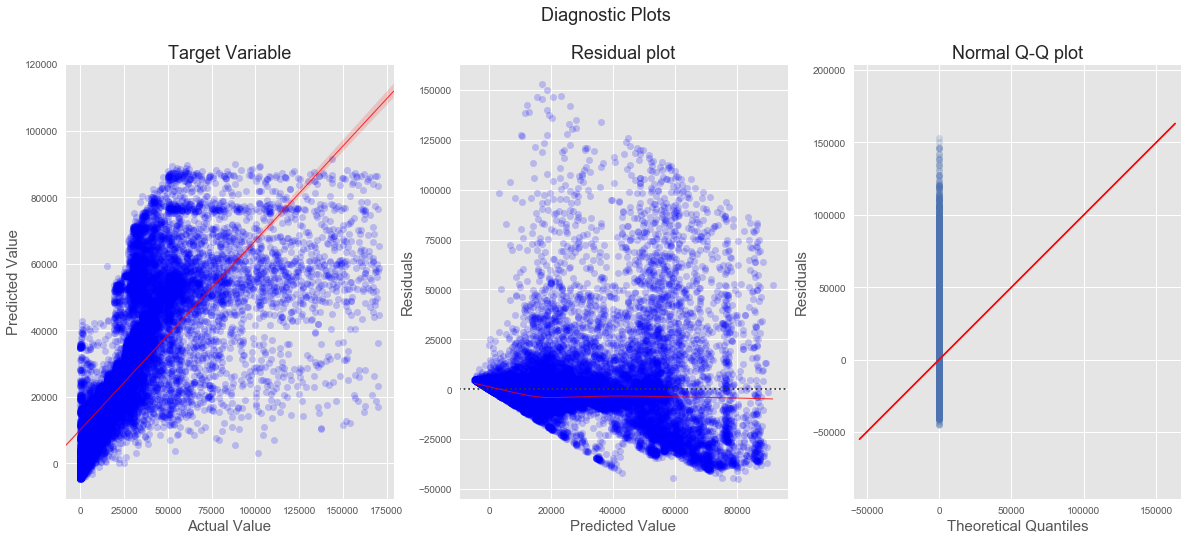

In [56]:
fig = diagnostic_plot(X_train_std, y_train, lr_base3_std);
fig.savefig('DiagnosticPlotNoOutliers.png', bbox_inches='tight');

Lasso Grid Search


/Users/sakina/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/sakina/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Lasso Grid Scores 0.567479817597


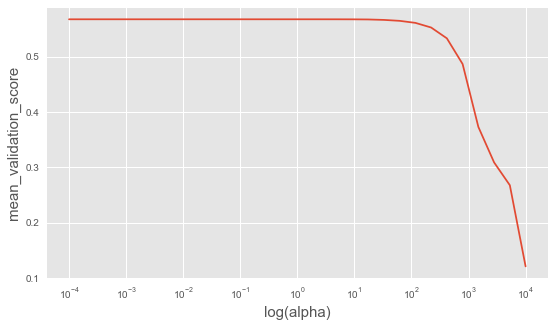

In [57]:
print("Lasso Grid Search")
lasso_grid_est = build_grid_search_est(Lasso(), X_train_std, y_train, cv=kfold,
                                       alpha=np.logspace(-4, 4, 30))
print("Lasso Grid Scores", lasso_grid_est.best_score_)

Ridge Grid Search


/Users/sakina/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/sakina/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Ridge Best Scores 0.567480384882


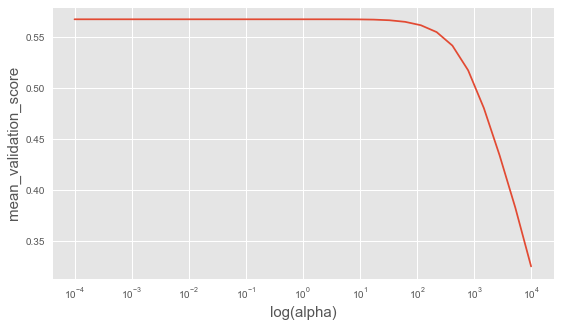

In [58]:
print("Ridge Grid Search")
ridge_grid_est = build_grid_search_est(Ridge(), X_train_std, y_train, cv=kfold,
                                       alpha=np.logspace(-4, 4, 30))
print("Ridge Best Scores", ridge_grid_est.best_score_)

**Upward / Downward Sloping - points to the presence of outliers or significant skew in the target distribution that distorts the quality of the fit. Consider removing outliers or smoothing the distribution (reframing the problem with a target that's less skewed, or using a log transform)**

# Model 3 - Using log of goal and pledged amount

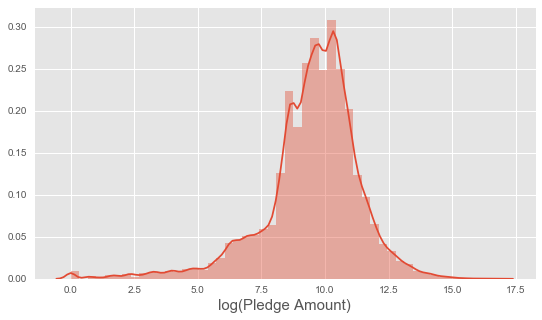

In [59]:
sns_plot = sns.distplot(project_df['pledged_log']);
sns_plot.set_xlabel("log(Pledge Amount)");
fig = sns_plot.get_figure()
fig.savefig('LogPledgeDistribution.png', bbox_inches='tight');

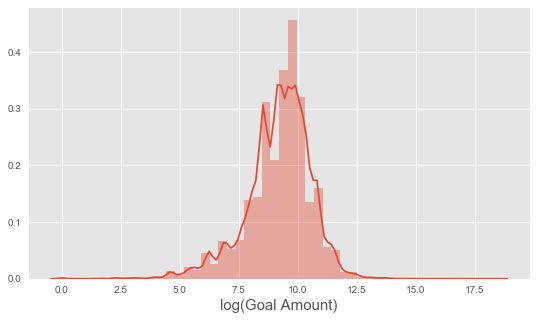

In [60]:
sns_plot = sns.distplot(project_df['goal_log']);
sns_plot.set_xlabel("log(Goal Amount)");

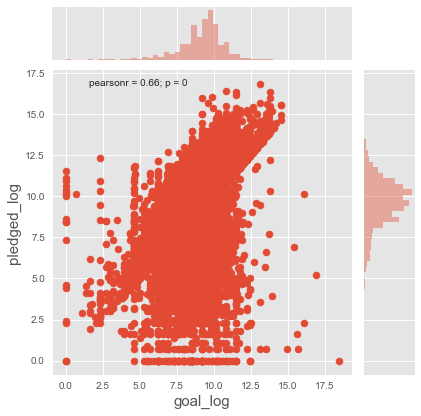

In [61]:
sns.jointplot('goal_log','pledged_log',project_df);

### Select feature and target columns

In [63]:
feature_col = ['category', 'goal_log', 'duration', 'rewards_count']
target_col = ['pledged_log']

project_sel_df1 = X_train_all[feature_col].join(y_train_all[target_col])
(project_sel_df1.columns, project_sel_df1.shape)

(Index(['category', 'goal_log', 'duration', 'rewards_count', 'pledged_log'], dtype='object'),
 (28196, 5))

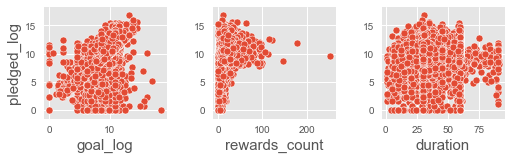

In [64]:
sns.pairplot(project_sel_df1, y_vars='pledged_log', x_vars= ['goal_log', 'rewards_count', 'duration']);

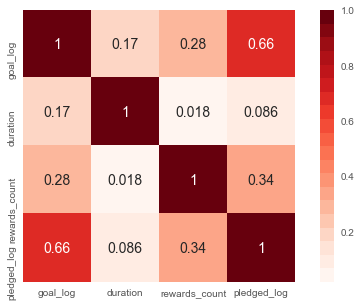

In [65]:
sns.heatmap(project_sel_df1.corr(),annot=True,square=True, 
            cmap=plt.cm.get_cmap('Reds', 20));

### Add dummy variables

In [66]:
category_dummy = pd.get_dummies(project_sel_df1['category'])
category_dummy.columns

project_sel_df1 = project_sel_df1.join(category_dummy)
project_sel_df1.drop(['category', 'Theater'], inplace=True, axis=1)
# we want to get rid of one dummy variable to avoid the dummy variable trap

In [67]:
X_train, y_train  = project_sel_df1.drop('pledged_log',axis=1), project_sel_df1['pledged_log']

### Check statistics using statsmodels

In [68]:
lr_model = sm.OLS(y_train,sm.add_constant(X_train))
results = lr_model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            pledged_log   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     4995.
Date:                Sun, 04 Feb 2018   Prob (F-statistic):               0.00
Time:                        15:08:37   Log-Likelihood:                -38825.
No. Observations:               28196   AIC:                         7.769e+04
Df Residuals:                   28178   BIC:                         7.783e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.2938      0.052     82.176      0.000       4.191       4.396
goal_log          0.5097      0.005     94.567      0.000       0.499       0.520
duration         -0.0012      0.001     -2.236      0.025      -0.002      -0.000
rewards_count     0.0218      0.001     27.936      0.000       0.020       0.023
Art               0.3082      0.031      9.919      0.000       0.247       0.369
Comics            0.3416      0.031     10.881      0.000       0.280       0.403
Crafts           -0.8719      0.032    -27.023      0.000      -0.935      -0.809
Dance            -0.5952      0.031    -19.044      0.000      -0.657      -0.534
Design            1.7630      0.032     55.674      0.000       1.701       1.825
Fashion           0.5562      0.031     17.902      0.000       0.495       0.617
Film & Video      0.8041      0.033     24.592      0.000       0.740       0.868
Food              0.5264      0.031     16.786      0.000       0.465       0.588
Games             1.7799      0.032     56.485      0.000       1.718       1.842
Journalism       -3.1755      0.032    -99.862      0.000      -3.238      -3.113
Music             0.5270      0.032     16.617      0.000       0.465       0.589
Photography      -0.2905      0.031     -9.270      0.000      -0.352      -0.229
Publishing        0.5651      0.031     18.076      0.000       0.504       0.626
Technology        1.6125      0.032     50.315      0.000       1.550       1.675
==============================================================================
Omnibus:                     4972.107   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            92717.349
Skew:                          -0.299   Prob(JB):                         0.00
Kurtosis:                      11.864   Cond. No.                         578.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Baseline: Linear Regression

In [69]:
# Standardize the training feature set
X_train_std = StandardScaler().fit_transform(X_train)

lr_base_std = LinearRegression()

scores = cross_val_score(lr_base_std, X_train_std, y_train, cv=kfold)
print('Baseline Linear Regression Cross validation - Model 3')
print('scores: ', scores)
print("Mean Score: ", np.mean(scores))

# Build the Model
lr_base_std.fit(X_train_std, y_train)

Baseline Linear Regression Cross validation - Model 3
scores:  [ 0.74436738  0.74226727  0.7597216   0.75040406  0.75431826]
Mean Score:  0.750215714295


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

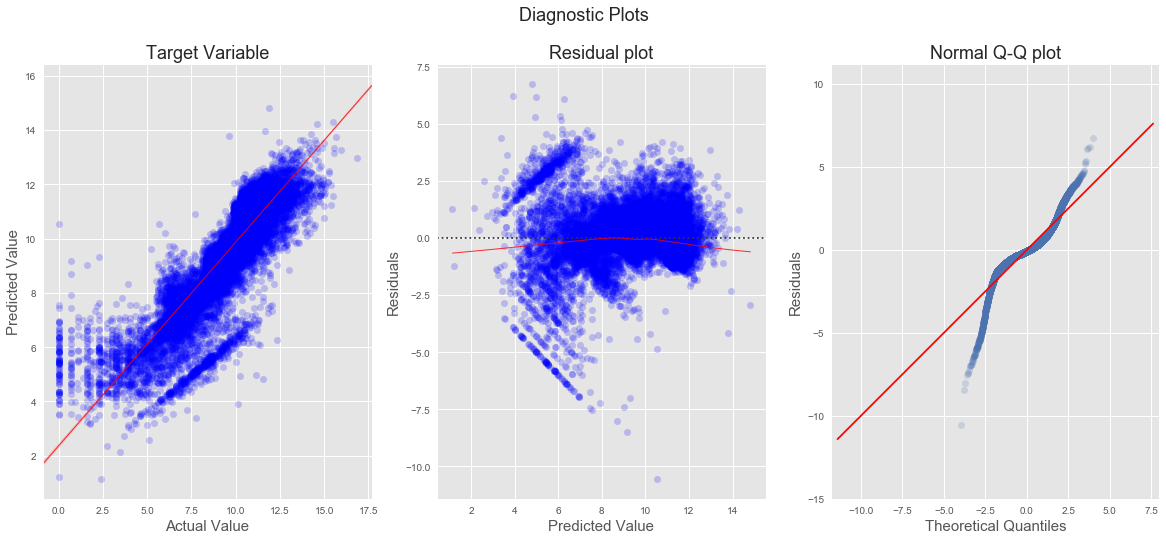

In [70]:
fig = diagnostic_plot(X_train_std, y_train, lr_base_std)

### Check model 3 with Regularization

Lasso Grid Search


/Users/sakina/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/sakina/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Lasso Best Score 0.750215371496


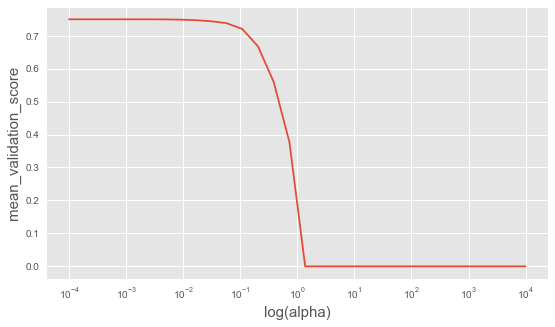

In [72]:
print("Lasso Grid Search")
lasso_grid_est = build_grid_search_est(Lasso(), X_train_std, y_train, cv=kfold,
                                       alpha=np.logspace(-4, 4, 30))

print("Lasso Best Score", lasso_grid_est.best_score_)

Ridge Grid Search


/Users/sakina/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/sakina/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Ridge Best Score 0.750216352841


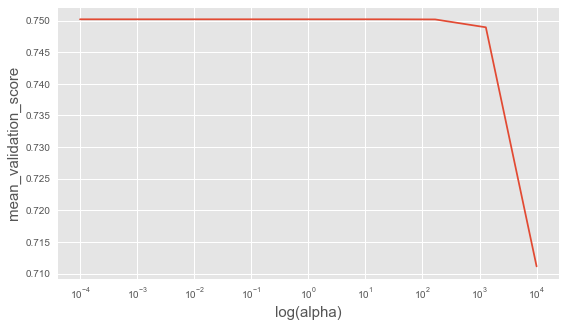

In [73]:
print("Ridge Grid Search")
ridge_grid_est = build_grid_search_est(Ridge(), X_train_std, y_train, cv=kfold,
                                       alpha=np.logspace(-4, 4, 10))

print("Ridge Best Score", ridge_grid_est.best_score_)

# Model 4 - Add polynomial features to Model 2

In [75]:
feature_col = ['category', 'goal_amount', 'duration', 'rewards_count']
target_col = ['pledged_amount']
project_sel_df4 = project_sel_df3.copy()

In [76]:
X_train, y_train  = project_sel_df4.drop('pledged_amount',axis=1), project_sel_df4['pledged_amount']
X_train = add_square_terms(X_train, ['goal_amount', 'duration', 'rewards_count'])
(X_train.shape, X_train.columns)

((25583, 20),
 Index(['goal_amount', 'duration', 'rewards_count', 'Art', 'Comics', 'Crafts',
        'Dance', 'Design', 'Fashion', 'Film & Video', 'Food', 'Games',
        'Journalism', 'Music', 'Photography', 'Publishing', 'Technology',
        'goal_amount**2', 'duration**2', 'rewards_count**2'],
       dtype='object'))

In [77]:
lrp_model = sm.OLS(y_train,sm.add_constant(X_train))
results = lrp_model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         pledged_amount   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     1688.
Date:                Sun, 04 Feb 2018   Prob (F-statistic):               0.00
Time:                        15:13:32   Log-Likelihood:            -2.8679e+05
No. Observations:               25583   AIC:                         5.736e+05
Df Residuals:                   25562   BIC:                         5.738e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1732.6638    865.803      2.001      0.045      35.640    3429.687
goal_amount          0.6006      0.033     18.083      0.000       0.535       0.666
duration            14.9030     39.544      0.377      0.706     -62.605      92.411
rewards_count      224.5576     23.678      9.484      0.000     178.147     270.968
Art               3368.4692    585.689      5.751      0.000    2220.486    4516.453
Comics            6464.6978    594.106     10.881      0.000    5300.216    7629.180
Crafts           -3025.7768    595.650     -5.080      0.000   -4193.284   -1858.269
Dance            -2297.2258    585.006     -3.927      0.000   -3443.870   -1150.581
Design            4.396e+04    653.764     67.246      0.000    4.27e+04    4.52e+04
Fashion           9397.5360    591.004     15.901      0.000    8239.135    1.06e+04
Film & Video       1.15e+04    693.232     16.590      0.000    1.01e+04    1.29e+04
Food              5961.5962    607.074      9.820      0.000    4771.696    7151.496
Games             4.251e+04    636.624     66.768      0.000    4.13e+04    4.38e+04
Journalism       -6315.4733    606.123    -10.419      0.000   -7503.509   -5127.438
Music             7218.3363    616.333     11.712      0.000    6010.288    8426.384
Photography       -817.6023    584.619     -1.399      0.162   -1963.488     328.284
Publishing        8204.1524    594.495     13.800      0.000    7038.909    9369.395
Technology        3.398e+04    680.197     49.962      0.000    3.27e+04    3.53e+04
goal_amount**2    4.041e-06   6.77e-07      5.967      0.000    2.71e-06    5.37e-06
duration**2         -0.1484      0.466     -0.319      0.750      -1.062       0.765
rewards_count**2    -0.4101      0.281     -1.459      0.145      -0.961       0.141
==============================================================================
Omnibus:                    16651.737   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           252465.370
Skew:                           2.941   Prob(JB):                         0.00
Kurtosis:                      17.222   Cond. No.                     9.82e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.82e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [78]:
lr_poly = LinearRegression()
scores = cross_val_score(lr_poly, X_train, y_train, cv=kfold)
print('Linear Regression with polynomials Cross validation')
print('scores: ', scores)
print("Mean Score: ", np.mean(scores))

# Build the Model
lr_poly.fit(X_train, y_train)

Linear Regression with polynomials Cross validation
scores:  [ 0.59193979  0.56178387  0.53931041  0.57295741  0.57341527]
Mean Score:  0.567881348913


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

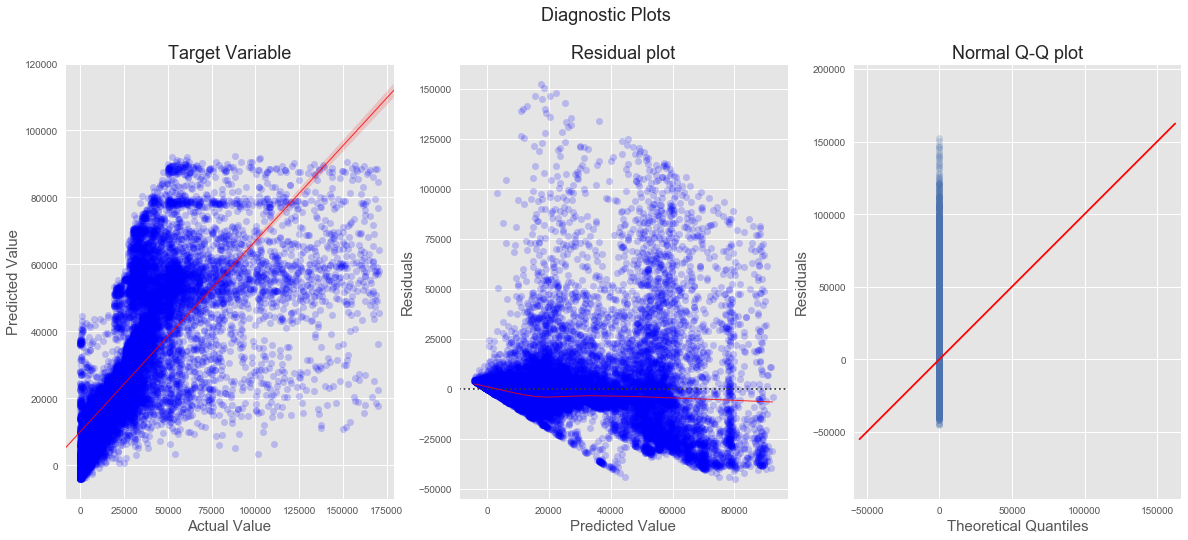

In [79]:
fig = diagnostic_plot(X_train, y_train, lr_poly)

Lasso Grid Search


/Users/sakina/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/sakina/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Lasso Best Score 0.567928768665


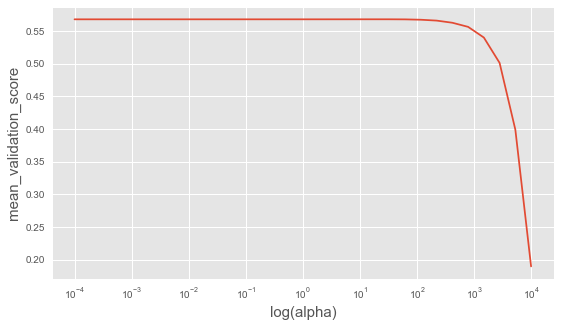

In [80]:
# Standardize the training feature set
X_train_std = StandardScaler().fit_transform(X_train)
print("Lasso Grid Search")
lasso_grid_est = build_grid_search_est(Lasso(), X_train_std, y_train, cv=kfold,
                                       alpha=np.logspace(-4, 4, 30))

print("Lasso Best Score", lasso_grid_est.best_score_)

Ridge Grid Search


/Users/sakina/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/sakina/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Ridge Best Score 0.567884902296


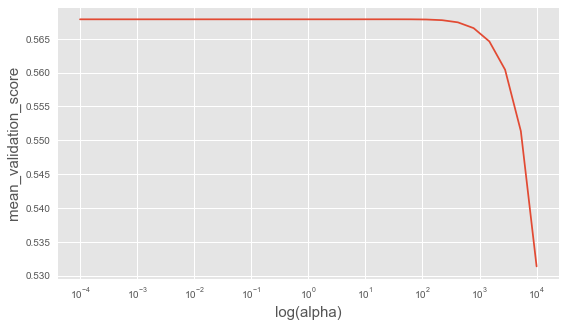

In [81]:
print("Ridge Grid Search")
ridge_grid_est = build_grid_search_est(Ridge(), X_train_std, y_train, cv=kfold,
                                       alpha=np.logspace(-4, 4, 30))

print("Ridge Best Score", ridge_grid_est.best_score_)

# Model 5 - Model 3 + add features (rewards_min, rewards_max, title_cnt, blurb_cnt)

In [82]:
feature_col = ['category', 'goal_log', 'duration', 'rewards_count',
               'rewards_min', 'rewards_max', 'title_wordcnt', 'blurb_wordcnt']
target_col = ['pledged_log']

project_sel_df5 = X_train_all[feature_col].join(y_train_all[target_col])
(project_sel_df5.shape, project_sel_df5.columns)

((28196, 9),
 Index(['category', 'goal_log', 'duration', 'rewards_count', 'rewards_min',
        'rewards_max', 'title_wordcnt', 'blurb_wordcnt', 'pledged_log'],
       dtype='object'))

In [83]:
category_dummy = pd.get_dummies(project_sel_df5['category'])
project_sel_df5 = project_sel_df5.join(category_dummy)
project_sel_df5.drop(['category', 'Theater'], inplace=True, axis=1)

In [84]:
X_train, y_train  = project_sel_df5.drop('pledged_log',axis=1), project_sel_df5['pledged_log']

In [85]:
lrm_model = sm.OLS(y_train,sm.add_constant(X_train))
results = lrm_model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            pledged_log   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     4058.
Date:                Sun, 04 Feb 2018   Prob (F-statistic):               0.00
Time:                        15:20:27   Log-Likelihood:                -38786.
No. Observations:               28196   AIC:                         7.762e+04
Df Residuals:                   28174   BIC:                         7.780e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.3687      0.060     73.315      0.000       4.252       4.485
goal_log          0.5038      0.006     89.102      0.000       0.493       0.515
duration         -0.0012      0.001     -2.205      0.027      -0.002      -0.000
rewards_count     0.0207      0.001     25.840      0.000       0.019       0.022
rewards_min      -0.0002   5.46e-05     -4.223      0.000      -0.000      -0.000
rewards_max     8.35e-06   2.19e-06      3.805      0.000    4.05e-06    1.27e-05
title_wordcnt     0.0128      0.002      5.798      0.000       0.008       0.017
blurb_wordcnt    -0.0056      0.001     -4.198      0.000      -0.008      -0.003
Art               0.3094      0.031      9.968      0.000       0.249       0.370
Comics            0.3588      0.032     11.372      0.000       0.297       0.421
Crafts           -0.8653      0.032    -26.822      0.000      -0.929      -0.802
Dance            -0.5905      0.031    -18.909      0.000      -0.652      -0.529
Design            1.7575      0.032     55.118      0.000       1.695       1.820
Fashion           0.5505      0.031     17.689      0.000       0.489       0.611
Film & Video      0.7808      0.034     23.282      0.000       0.715       0.847
Food              0.5212      0.031     16.630      0.000       0.460       0.583
Games             1.7963      0.032     56.775      0.000       1.734       1.858
Journalism       -3.1586      0.032    -99.253      0.000      -3.221      -3.096
Music             0.5119      0.032     16.054      0.000       0.449       0.574
Photography      -0.2894      0.031     -9.246      0.000      -0.351      -0.228
Publishing        0.5611      0.031     17.958      0.000       0.500       0.622
Technology        1.5984      0.032     49.768      0.000       1.535       1.661
==============================================================================
Omnibus:                     4953.419   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            91341.510
Skew:                          -0.299   Prob(JB):                         0.00
Kurtosis:                      11.797   Cond. No.                     6.67e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.67e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [86]:
# Standardize the training feature set
X_train_std = StandardScaler().fit_transform(X_train)
lr_more = LinearRegression()
scores = cross_val_score(lr_more, X_train_std, y_train, cv=kfold)
print('Linear Regression with more features Cross validation')
print('scores: ', scores)
print("Mean Score: ", np.mean(scores))

# Build the Model
lr_more.fit(X_train, y_train)

Linear Regression with more features Cross validation
scores:  [ 0.74491977  0.74262868  0.76045157  0.75135256  0.75463974]
Mean Score:  0.750798465669


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Add regularization

Lasso Grid Search


/Users/sakina/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/sakina/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Lasso Best Score: 0.750797959214


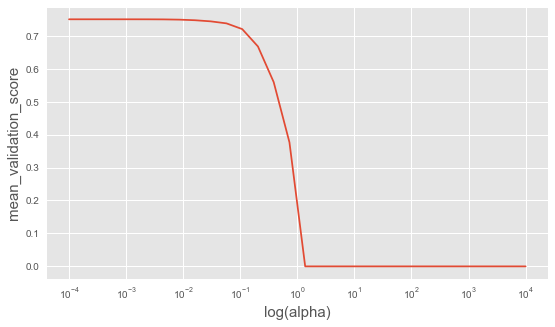

In [87]:
print("Lasso Grid Search")
lasso_grid_est = build_grid_search_est(Lasso(), X_train_std, y_train, cv=kfold,
                                       alpha=np.logspace(-4, 4, 30))

print("Lasso Best Score:", lasso_grid_est.best_score_)

Ridge Grid Search


/Users/sakina/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/sakina/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Ridge Best Score: 0.750799120052


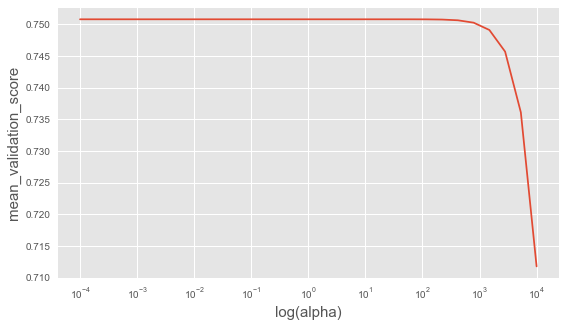

In [88]:
print("Ridge Grid Search")
ridge_grid_est = build_grid_search_est(Ridge(), X_train_std, y_train, cv=kfold,
                                       alpha=np.logspace(-4, 4, 30))

print("Ridge Best Score:", ridge_grid_est.best_score_)

### Add polynomial features

In [89]:
feature_col = ['goal_log', 'duration', 'rewards_count', 'rewards_min', 
               'rewards_max','title_wordcnt', 'blurb_wordcnt']
X_train = add_square_terms(X_train, feature_col)
(X_train.shape, X_train.columns)

((28196, 28),
 Index(['goal_log', 'duration', 'rewards_count', 'rewards_min', 'rewards_max',
        'title_wordcnt', 'blurb_wordcnt', 'Art', 'Comics', 'Crafts', 'Dance',
        'Design', 'Fashion', 'Film & Video', 'Food', 'Games', 'Journalism',
        'Music', 'Photography', 'Publishing', 'Technology', 'goal_log**2',
        'duration**2', 'rewards_count**2', 'rewards_min**2', 'rewards_max**2',
        'title_wordcnt**2', 'blurb_wordcnt**2'],
       dtype='object'))

In [90]:
lrp1_model = sm.OLS(y_train,sm.add_constant(X_train))
results = lrp1_model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            pledged_log   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     3066.
Date:                Sun, 04 Feb 2018   Prob (F-statistic):               0.00
Time:                        15:28:04   Log-Likelihood:                -38705.
No. Observations:               28196   AIC:                         7.747e+04
Df Residuals:                   28167   BIC:                         7.771e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                4.2667      0.138     31.003      0.000       3.997       4.536
goal_log             0.4334      0.027     16.157      0.000       0.381       0.486
duration             0.0004      0.002      0.204      0.838      -0.004       0.005
rewards_count        0.0311      0.001     24.999      0.000       0.029       0.034
rewards_min       6.635e-05      0.000      0.511      0.610      -0.000       0.000
rewards_max        4.66e-07   5.93e-06      0.079      0.937   -1.12e-05    1.21e-05
title_wordcnt        0.0374      0.009      4.051      0.000       0.019       0.055
blurb_wordcnt        0.0262      0.007      3.521      0.000       0.012       0.041
Art                  0.2911      0.031      9.392      0.000       0.230       0.352
Comics               0.3153      0.032      9.917      0.000       0.253       0.378
Crafts              -0.8796      0.033    -26.904      0.000      -0.944      -0.816
Dance               -0.5913      0.031    -18.948      0.000      -0.652      -0.530
Design               1.7276      0.032     53.390      0.000       1.664       1.791
Fashion              0.5253      0.031     16.849      0.000       0.464       0.586
Film & Video         0.7514      0.034     22.102      0.000       0.685       0.818
Food                 0.4977      0.031     15.846      0.000       0.436       0.559
Games                1.7688      0.032     55.168      0.000       1.706       1.832
Journalism          -3.1493      0.032    -98.124      0.000      -3.212      -3.086
Music                0.4880      0.032     15.236      0.000       0.425       0.551
Photography         -0.3020      0.031     -9.611      0.000      -0.364      -0.240
Publishing           0.5402      0.031     17.292      0.000       0.479       0.601
Technology           1.5673      0.033     47.925      0.000       1.503       1.631
goal_log**2          0.0039      0.002      2.483      0.013       0.001       0.007
duration**2      -1.797e-05   2.45e-05     -0.733      0.464   -6.61e-05    3.01e-05
rewards_count**2    -0.0002   1.47e-05    -11.073      0.000      -0.000      -0.000
rewards_min**2   -3.631e-08   1.56e-08     -2.331      0.020   -6.68e-08   -5.78e-09
rewards_max**2    4.087e-10   5.22e-10      0.783      0.434   -6.15e-10    1.43e-09
title_wordcnt**2    -0.0020      0.001     -2.827      0.005      -0.003      -0.001
blurb_wordcnt**2    -0.0009      0.000     -4.321      0.000      -0.001      -0.000
==============================================================================
Omnibus:                     5035.445   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            92512.388
Skew:                          -0.324   Prob(JB):                         0.00
Kurtosis:                      11.850   Cond. N

# Model 6 - log target + log numerical features

In [16]:
feature_col = ['category', 'goal_log', 'duration', 'rewards_log', 'project_status']
target_col = ['pledged_log']

project_sel_df6 = X_train_all[feature_col].join(y_train_all[target_col])
(project_sel_df6.columns, project_sel_df6.shape)

(Index(['category', 'goal_log', 'duration', 'rewards_log', 'project_status',
        'pledged_log'],
       dtype='object'), (28196, 6))

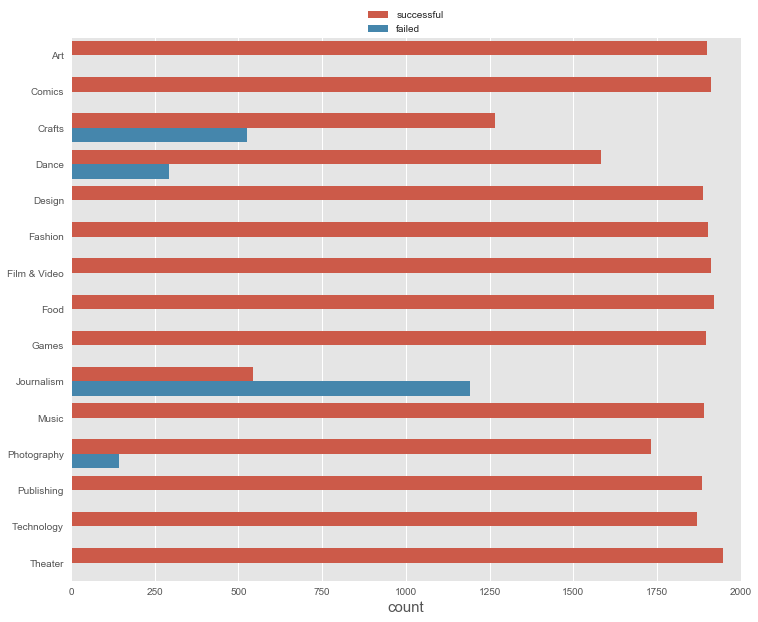

In [92]:
fig = plt.figure(figsize=(12,10));
sns.countplot(y='category',hue='project_status', data=project_sel_df6, 
             order = project_sel_df6['category'].sort_values().unique());
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.065));
plt.ylabel('');
plt.xlim([0, 2000])
fig.savefig('TrainPortfolio.png', bbox_inches='tight');

In [17]:
project_sel_df6.drop(['project_status'], inplace=True, axis=1)

In [18]:
category_dummy = pd.get_dummies(project_sel_df6['category'])
project_sel_df6 = project_sel_df6.join(category_dummy)
project_sel_df6.drop(['category', 'Theater'], inplace=True, axis=1)

In [19]:
X_train, y_train  = project_sel_df6.drop('pledged_log',axis=1), project_sel_df6['pledged_log']

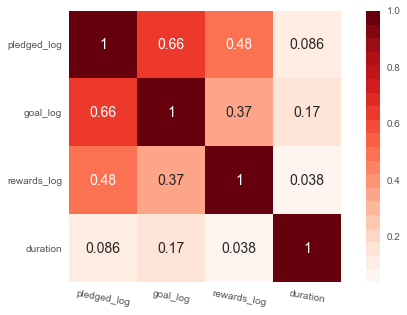

In [160]:
sns_plot = sns.heatmap(project_sel_df6[['pledged_log', 'goal_log', 'rewards_log', 'duration']].corr(),annot=True, 
                       square=True, cmap=plt.cm.get_cmap('Reds', 20));
plt.yticks(rotation=0) 
plt.xticks(rotation=-10) 
fig = sns_plot.get_figure()
fig.savefig('CorrMatrix.png', bbox_inches='tight');

sns.pairplot(project_sel_df6, y_vars='pledged_log', x_vars= ['goal_log', 'rewards_log', 'duration']);

In [98]:
lr_loglog_model = sm.OLS(y_train,sm.add_constant(X_train))
results = lr_loglog_model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            pledged_log   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     5193.
Date:                Sun, 04 Feb 2018   Prob (F-statistic):               0.00
Time:                        15:29:45   Log-Likelihood:                -38412.
No. Observations:               28196   AIC:                         7.686e+04
Df Residuals:                   28178   BIC:                         7.701e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.8229      0.053     72.643      0.000       3.720       3.926
goal_log         0.4844      0.005     90.004      0.000       0.474       0.495
duration        -0.0012      0.001     -2.298      0.022      -0.002      -0.000
rewards_log      0.4234      0.010     40.512      0.000       0.403       0.444
Art              0.2738      0.031      8.940      0.000       0.214       0.334
Comics           0.2644      0.031      8.532      0.000       0.204       0.325
Crafts          -0.8584      0.032    -27.045      0.000      -0.921      -0.796
Dance           -0.5400      0.031    -17.505      0.000      -0.601      -0.480
Design           1.7501      0.031     56.085      0.000       1.689       1.811
Fashion          0.5157      0.031     16.825      0.000       0.456       0.576
Film & Video     0.7619      0.032     23.678      0.000       0.699       0.825
Food             0.4760      0.031     15.378      0.000       0.415       0.537
Games            1.7852      0.031     57.537      0.000       1.724       1.846
Journalism      -2.9924      0.032    -94.007      0.000      -3.055      -2.930
Music            0.4635      0.031     14.811      0.000       0.402       0.525
Photography     -0.2826      0.031     -9.154      0.000      -0.343      -0.222
Publishing       0.5323      0.031     17.274      0.000       0.472       0.593
Technology       1.5975      0.032     50.576      0.000       1.536       1.659
==============================================================================
Omnibus:                     4640.046   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            79474.137
Skew:                          -0.247   Prob(JB):                         0.00
Kurtosis:                      11.210   Cond. No.                         549.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
# Standardize the training feature set
X_train_std = StandardScaler().fit_transform(X_train)
lr_loglog_model = LinearRegression()
scores = cross_val_score(lr_loglog_model, X_train_std, y_train, cv=kfold)
print('Linear Regression with log-log: Cross validation - Model 6')
print('scores: ', scores)
print("Mean Score: ", np.mean(scores))

# Build the Model
lr_loglog_model.fit(X_train_std, y_train)

Linear Regression with log-log: Cross validation - Model 6
scores:  [ 0.75109497  0.75179425  0.76497125  0.75919016  0.75960158]
Mean Score:  0.757330441113


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

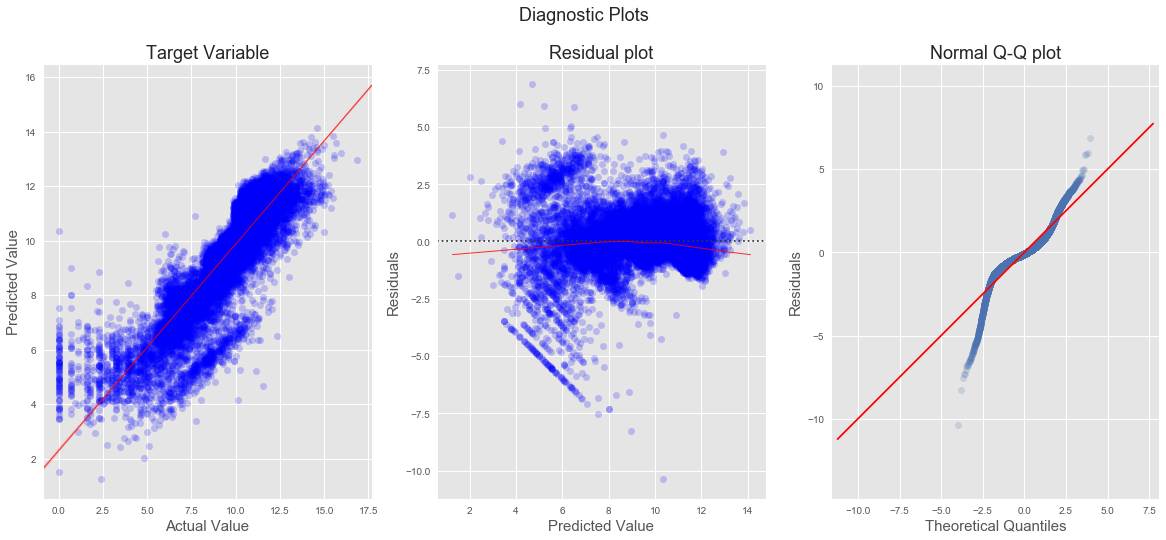

In [100]:
fig = diagnostic_plot(X_train_std, y_train, lr_loglog_model)
fig.savefig('DiagnosticPlotTrainSet.png', bbox_inches='tight');

In [101]:
y_train_pred = lr_loglog_model.predict(X_train_std)
print('R2: %.4f\nRMSE: %.4f' %(r2_score(y_train, y_train_pred), RMSE(y_train, y_train_pred)))

R2: 0.7580
RMSE: 0.9449


In [23]:
all_coef = lr_loglog_model.coef_
all_coef = np.insert(all_coef, 0, lr_loglog_model.intercept_)
index = ['intercept']
index.extend(list(X_train.columns))
lm_coef = pd.Series(all_coef, index=index)
pp.pprint(lm_coef)

intercept       9.471580
goal_log        0.675578
duration       -0.013265
rewards_log     0.270704
Art             0.068616
Comics          0.066432
Crafts         -0.209415
Dance          -0.134621
Design          0.437439
Fashion         0.129303
Film & Video    0.191457
Food            0.119935
Games           0.447208
Journalism     -0.719091
Music           0.115911
Photography    -0.070417
Publishing      0.132956
Technology      0.397638
dtype: float64


### Add regularization

Lasso Grid Search


/Users/sakina/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/sakina/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Lasso Best Score: 0.757330061145


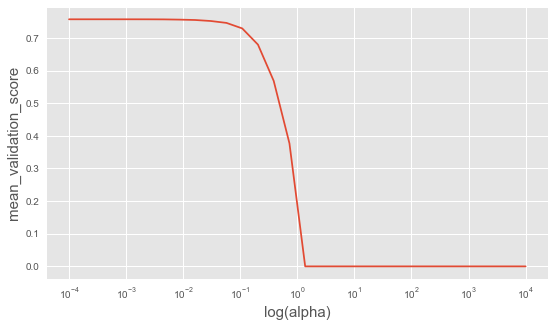

In [103]:
print("Lasso Grid Search")
lasso_grid_est = build_grid_search_est(Lasso(), X_train_std, y_train, cv=kfold,
                                       alpha=np.logspace(-4, 4, 30))

print("Lasso Best Score:", lasso_grid_est.best_score_)

Ridge Grid Search


/Users/sakina/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/sakina/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Ridge Best Score: 0.757331116712


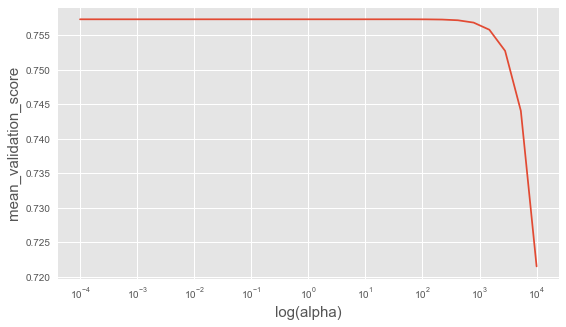

In [104]:
print("Ridge Grid Search")
ridge_grid_est = build_grid_search_est(Ridge(), X_train_std, y_train, cv=kfold,
                                       alpha=np.logspace(-4, 4, 30))

print("Ridge Best Score:", ridge_grid_est.best_score_)

### Lars Path

In [105]:
print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_train_std, y_train.values, method='lasso', verbose=True)

Computing regularization path using the LARS ...
.

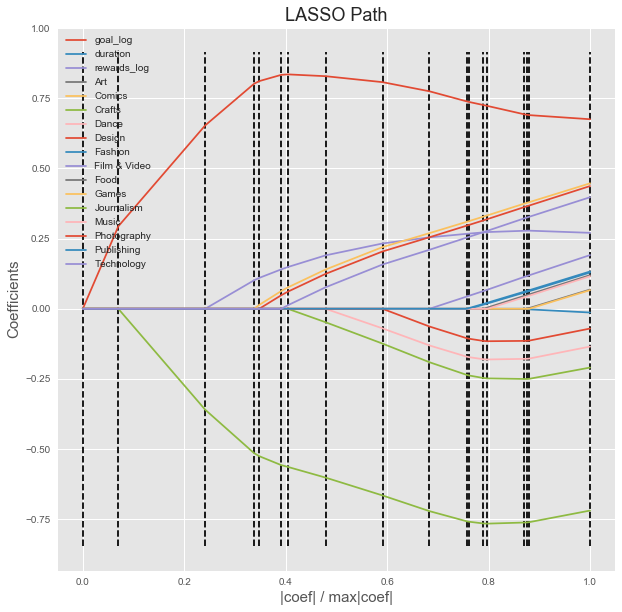

In [106]:
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_train.columns, loc='upper left')
plt.show()

# Model 7 - Model 6 + state categorical variable

In [107]:
feature_col = ['category', 'goal_log', 'duration', 'rewards_log', 'state']
target_col = ['pledged_log']

project_sel_df7 = X_train_all[feature_col].join(y_train_all[target_col])

In [108]:
category_dummy = pd.get_dummies(project_sel_df7['category'])
state_dummy = pd.get_dummies(project_sel_df7['state'])
[category_dummy.columns, state_dummy.columns]

[Index(['Art', 'Comics', 'Crafts', 'Dance', 'Design', 'Fashion', 'Film & Video',
        'Food', 'Games', 'Journalism', 'Music', 'Photography', 'Publishing',
        'Technology', 'Theater'],
       dtype='object'),
 Index(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI',
        'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN',
        'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH',
        'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA',
        'WI', 'WV', 'WY'],
       dtype='object')]

In [109]:
project_sel_df7 = project_sel_df7.join(category_dummy)
project_sel_df7 = project_sel_df7.join(state_dummy)
project_sel_df7.drop(['category', 'Theater', 'state', 'ND'], inplace=True, axis=1)
(project_sel_df7.columns, project_sel_df7.shape)

(Index(['goal_log', 'duration', 'rewards_log', 'pledged_log', 'Art', 'Comics',
        'Crafts', 'Dance', 'Design', 'Fashion', 'Film & Video', 'Food', 'Games',
        'Journalism', 'Music', 'Photography', 'Publishing', 'Technology', 'AK',
        'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA',
        'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO',
        'MS', 'MT', 'NC', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR',
        'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV',
        'WY'],
       dtype='object'), (28196, 68))

In [110]:
X_train, y_train  = project_sel_df7.drop('pledged_log',axis=1), project_sel_df7['pledged_log']

In [111]:
lrm1_model = sm.OLS(y_train,sm.add_constant(X_train))
results = lrm1_model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            pledged_log   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     1331.
Date:                Sun, 04 Feb 2018   Prob (F-statistic):               0.00
Time:                        15:35:30   Log-Likelihood:                -38287.
No. Observations:               28196   AIC:                         7.671e+04
Df Residuals:                   28128   BIC:                         7.727e+04
Df Model:                          67                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.5866      0.228     15.737      0.000       3.140       4.033
goal_log         0.4780      0.005     88.489      0.000       0.467       0.489
duration        -0.0013      0.001     -2.418      0.016      -0.002      -0.000
rewards_log      0.4221      0.010     40.455      0.000       0.402       0.443
Art              0.2965      0.031      9.649      0.000       0.236       0.357
Comics           0.2969      0.031      9.488      0.000       0.236       0.358
Crafts          -0.8146      0.032    -25.383      0.000      -0.878      -0.752
Dance           -0.5319      0.031    -17.266      0.000      -0.592      -0.472
Design           1.7645      0.032     55.994      0.000       1.703       1.826
Fashion          0.5320      0.031     17.288      0.000       0.472       0.592
Film & Video     0.7750      0.032     23.995      0.000       0.712       0.838
Food             0.5100      0.031     16.314      0.000       0.449       0.571
Games            1.8250      0.032     57.654      0.000       1.763       1.887
Journalism      -2.9505      0.032    -92.027      0.000      -3.013      -2.888
Music            0.4945      0.032     15.504      0.000       0.432       0.557
Photography     -0.2576      0.031     -8.297      0.000      -0.318      -0.197
Publishing       0.5545      0.031     17.878      0.000       0.494       0.615
Technology       1.6092      0.032     50.281      0.000       1.547       1.672
AK               0.4060      0.249      1.633      0.103      -0.081       0.893
AL               0.1750      0.238      0.736      0.462      -0.291       0.641
AR               0.0499      0.250      0.199      0.842      -0.440       0.540
AZ               0.2979      0.227      1.313      0.189      -0.147       0.743
CA               0.3460      0.222      1.556      0.120      -0.090       0.782
CO               0.1449      0.225      0.643      0.520      -0.297       0.586
CT               0.2805      0.232      1.207      0.228      -0.175       0.736
DC               0.3889      0.227      1.710      0.087      -0.057       0.835
DE               0.4191      0.256      1.637      0.102      -0.083       0.921
FL               0.0745      0.224      0.332      0.740      -0.365       0.514
GA               0.2787      0.226      1.234      0.217      -0.164       0.721
HI               0.1850      0.234      0.791      0.429      -0.274       0.643
IA               0.0721      0.244      0.296      0.767      -0.406       0.550
ID               0.3243      0.237      1.369      0.171      -0.140       0.788
IL               0.3403      0.224      1.520      0.129      -0.099       0.779
IN               0.0768      0.232      0.330      0.741      -0.379       0.532
KS               0.1523      0.248      0.615      0.539      -0.333       0.638
KY   

In [113]:
# Standardize the training feature set
X_train_std = StandardScaler().fit_transform(X_train)
lr_state_model = LinearRegression()
scores = cross_val_score(lr_state_model, X_train_std, y_train, cv=kfold)
print('Linear Regression with log-log: Cross validation - Model 6')
print('scores: ', scores)
print("Mean Score: ", np.mean(scores))

# Build the Model
lr_state_model.fit(X_train_std, y_train)

Linear Regression with log-log: Cross validation - Model 6
scores:  [ 0.75012198  0.75338029  0.76559323  0.76049746  0.76073654]
Mean Score:  0.75806590072


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Lasso Grid Search


/Users/sakina/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/sakina/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Lasso Best Score: 0.758162399733


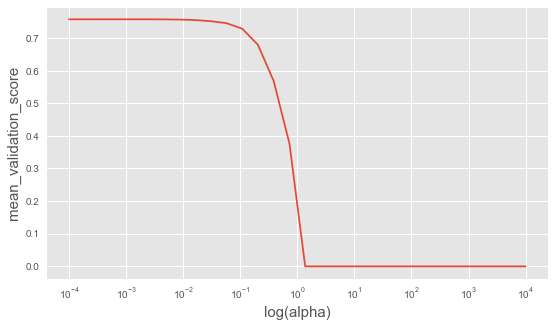

In [112]:
print("Lasso Grid Search")
lasso_grid_est = build_grid_search_est(Lasso(), X_train_std, y_train, cv=kfold,
                                       alpha=np.logspace(-4, 4, 30))

print("Lasso Best Score:", lasso_grid_est.best_score_)

Ridge Grid Search


/Users/sakina/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/sakina/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Ridge Best Score: 0.758093993823


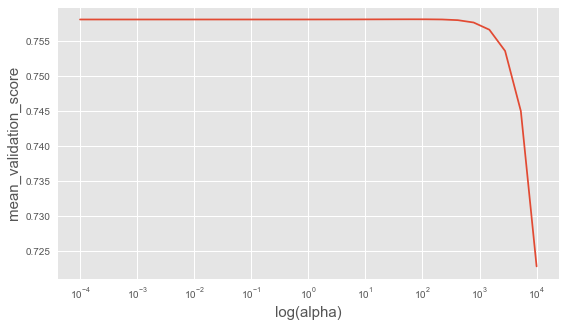

In [114]:
print("Ridge Grid Search")
ridge_grid_est = build_grid_search_est(Ridge(), X_train_std, y_train, cv=kfold,
                                       alpha=np.logspace(-4, 4, 30))

print("Ridge Best Score:", ridge_grid_est.best_score_)

# Model 8 - remove outliers and use log target and log numerical features

In [123]:
feature_col = ['category', 'goal_amount', 'duration', 'rewards_count']
target_col = ['pledged_amount']

project_sel_df8 = X_train_all[feature_col].join(y_train_all[target_col])

In [124]:
# remove outliers from pledged_amount
threshold = project_sel_df8['pledged_amount'].quantile(.95)
project_sel_df8 = project_sel_df8[project_sel_df8['pledged_amount']<=threshold]
project_sel_df8.shape

(26786, 5)

In [125]:
# remove outliers from goal_amount
threshold = project_sel_df8['goal_amount'].quantile(.95)
project_sel_df8 = project_sel_df8[project_sel_df8['goal_amount']<=threshold]
project_sel_df8.shape

(25583, 5)

In [126]:
project_sel_df8['pledged_log'] = project_sel_df8['pledged_amount'].apply(lambda x : np.log(x))
project_sel_df8['goal_log'] = project_sel_df8['goal_amount'].apply(lambda x : np.log(x))
project_sel_df8['rewards_log'] = project_sel_df8['rewards_count'].apply(lambda x : np.log(x) if x>0 else -10)
project_sel_df8.drop(['pledged_amount', 'goal_amount', 'rewards_count'], inplace=True, axis=1)

In [127]:
category_dummy = pd.get_dummies(project_sel_df8['category'])

project_sel_df8 = project_sel_df8.join(category_dummy)
project_sel_df8.drop(['category', 'Theater'], inplace=True, axis=1)
(project_sel_df8.columns, project_sel_df8.shape)

(Index(['duration', 'pledged_log', 'goal_log', 'rewards_log', 'Art', 'Comics',
        'Crafts', 'Dance', 'Design', 'Fashion', 'Film & Video', 'Food', 'Games',
        'Journalism', 'Music', 'Photography', 'Publishing', 'Technology'],
       dtype='object'), (25583, 18))

In [128]:
X_train, y_train  = project_sel_df8.drop('pledged_log',axis=1), project_sel_df8['pledged_log']

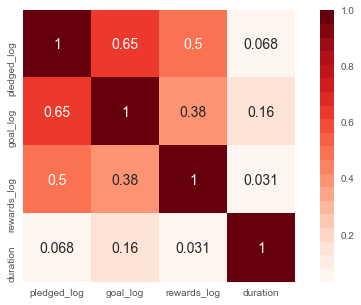

In [129]:
sns.heatmap(project_sel_df8[['pledged_log', 'goal_log', 'rewards_log', 'duration']].corr(), annot=True,
            square=True, cmap=plt.cm.get_cmap('Reds', 20));

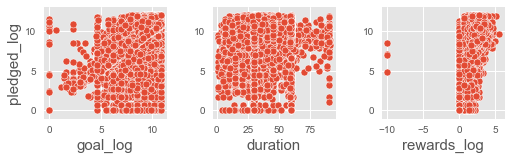

In [130]:
sns.pairplot(project_sel_df8, y_vars = 'pledged_log', x_vars = ['goal_log', 'duration', 'rewards_log']);

In [131]:
lr_outlog_model = sm.OLS(y_train,sm.add_constant(X_train))
results = lr_outlog_model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            pledged_log   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     4598.
Date:                Sun, 04 Feb 2018   Prob (F-statistic):               0.00
Time:                        15:49:32   Log-Likelihood:                -32648.
No. Observations:               25583   AIC:                         6.533e+04
Df Residuals:                   25565   BIC:                         6.548e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.0300      0.053     76.341      0.000       3.927       4.134
duration        -0.0017      0.001     -3.364      0.001      -0.003      -0.001
goal_log         0.4669      0.006     83.741      0.000       0.456       0.478
rewards_log      0.4002      0.010     40.330      0.000       0.381       0.420
Art              0.2719      0.028      9.598      0.000       0.216       0.327
Comics           0.2591      0.029      9.046      0.000       0.203       0.315
Crafts          -0.8567      0.029    -29.045      0.000      -0.915      -0.799
Dance           -0.5418      0.028    -19.038      0.000      -0.598      -0.486
Design           1.5084      0.031     48.534      0.000       1.447       1.569
Fashion          0.4585      0.028     16.093      0.000       0.403       0.514
Film & Video     0.7160      0.032     22.579      0.000       0.654       0.778
Food             0.4670      0.029     16.192      0.000       0.410       0.523
Games            1.5554      0.030     51.038      0.000       1.496       1.615
Journalism      -2.8909      0.030    -97.003      0.000      -2.949      -2.832
Music            0.4768      0.029     16.374      0.000       0.420       0.534
Photography     -0.3004      0.029    -10.501      0.000      -0.356      -0.244
Publishing       0.5245      0.029     18.359      0.000       0.468       0.580
Technology       1.2586      0.032     39.090      0.000       1.195       1.322
==============================================================================
Omnibus:                     5057.953   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            91915.484
Skew:                          -0.456   Prob(JB):                         0.00
Kurtosis:                      12.241   Cond. No.                         524.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [132]:
# Standardize the training feature set
X_train_std = StandardScaler().fit_transform(X_train)
lr_outlog = LinearRegression()
scores = cross_val_score(lr_outlog, X_train_std, y_train, cv=kfold)
print('Linear Regression Cross validation - Model 8')
print('scores: ', scores)
print("Mean Score: ", np.mean(scores))

# Build the Model
lr_outlog.fit(X_train_std, y_train)

Linear Regression Cross validation - Model 8
scores:  [ 0.75741598  0.75797253  0.75498003  0.74500825  0.75046272]
Mean Score:  0.753167902388


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Add regularization

Lasso Grid Search


/Users/sakina/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/sakina/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Lasso Best Score: 0.753168277379


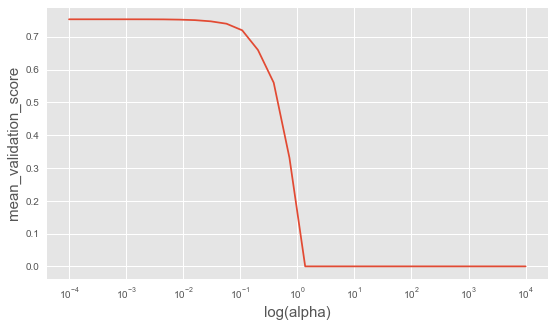

In [133]:
print("Lasso Grid Search")
lasso_grid_est = build_grid_search_est(Lasso(), X_train_std, y_train, cv=kfold,
                                       alpha=np.logspace(-4, 4, 30))

print("Lasso Best Score:", lasso_grid_est.best_score_)

Ridge Grid Search


/Users/sakina/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/sakina/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Ridge Best Score: 0.753168811942


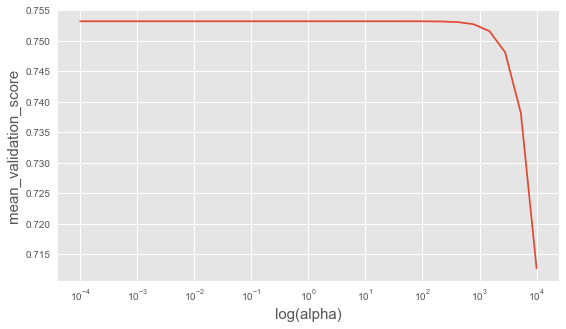

In [134]:
print("Ridge Grid Search")
ridge_grid_est = build_grid_search_est(Ridge(), X_train_std, y_train, cv=kfold,
                                       alpha=np.logspace(-4, 4, 30))
print("Ridge Best Score:", ridge_grid_est.best_score_)

# Model 9 - Model 6 + launch date quarter categorical variable

In [115]:
feature_col = ['category', 'goal_log', 'duration', 'rewards_log', 'launch_quarter']
target_col = ['pledged_log']

project_sel_df9 = X_train_all[feature_col].join(y_train_all[target_col])

In [116]:
category_dummy = pd.get_dummies(project_sel_df9['category'])
quarter_dummy = pd.get_dummies(project_sel_df9['launch_quarter'], prefix='Q')
[category_dummy.columns, quarter_dummy.columns]

[Index(['Art', 'Comics', 'Crafts', 'Dance', 'Design', 'Fashion', 'Film & Video',
        'Food', 'Games', 'Journalism', 'Music', 'Photography', 'Publishing',
        'Technology', 'Theater'],
       dtype='object'), Index(['Q_1', 'Q_2', 'Q_3', 'Q_4'], dtype='object')]

In [117]:
project_sel_df9 = project_sel_df9.join(category_dummy)
project_sel_df9 = project_sel_df9.join(quarter_dummy)
project_sel_df9.drop(['category', 'Theater', 'launch_quarter', 'Q_1'], inplace=True, axis=1)
(project_sel_df9.columns, project_sel_df9.shape)

(Index(['goal_log', 'duration', 'rewards_log', 'pledged_log', 'Art', 'Comics',
        'Crafts', 'Dance', 'Design', 'Fashion', 'Film & Video', 'Food', 'Games',
        'Journalism', 'Music', 'Photography', 'Publishing', 'Technology', 'Q_2',
        'Q_3', 'Q_4'],
       dtype='object'), (28196, 21))

In [118]:
X_train, y_train  = project_sel_df9.drop('pledged_log',axis=1), project_sel_df9['pledged_log']

In [119]:
lrm2_model = sm.OLS(y_train,sm.add_constant(X_train))
results = lrm2_model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            pledged_log   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     4413.
Date:                Sun, 04 Feb 2018   Prob (F-statistic):               0.00
Time:                        15:41:56   Log-Likelihood:                -38411.
No. Observations:               28196   AIC:                         7.686e+04
Df Residuals:                   28175   BIC:                         7.704e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.8215      0.053     71.459      0.000       3.717       3.926
goal_log         0.4843      0.005     89.968      0.000       0.474       0.495
duration        -0.0012      0.001     -2.300      0.021      -0.002      -0.000
rewards_log      0.4233      0.010     40.488      0.000       0.403       0.444
Art              0.2741      0.031      8.947      0.000       0.214       0.334
Comics           0.2647      0.031      8.539      0.000       0.204       0.325
Crafts          -0.8579      0.032    -27.012      0.000      -0.920      -0.796
Dance           -0.5399      0.031    -17.493      0.000      -0.600      -0.479
Design           1.7504      0.031     56.058      0.000       1.689       1.812
Fashion          0.5159      0.031     16.818      0.000       0.456       0.576
Film & Video     0.7621      0.032     23.678      0.000       0.699       0.825
Food             0.4763      0.031     15.381      0.000       0.416       0.537
Games            1.7857      0.031     57.527      0.000       1.725       1.847
Journalism      -2.9918      0.032    -93.938      0.000      -3.054      -2.929
Music            0.4639      0.031     14.811      0.000       0.402       0.525
Photography     -0.2824      0.031     -9.143      0.000      -0.343      -0.222
Publishing       0.5326      0.031     17.274      0.000       0.472       0.593
Technology       1.5979      0.032     50.557      0.000       1.536       1.660
Q_2              0.0071      0.016      0.447      0.655      -0.024       0.038
Q_3             -0.0035      0.016     -0.216      0.829      -0.035       0.028
Q_4              0.0042      0.016      0.257      0.797      -0.028       0.036
==============================================================================
Omnibus:                     4637.788   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            79412.043
Skew:                          -0.246   Prob(JB):                         0.00
Kurtosis:                      11.207   Cond. No.                         550.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [120]:
# Standardize the training feature set
X_train_std = StandardScaler().fit_transform(X_train)
lr_qtr_model = LinearRegression()
scores = cross_val_score(lr_qtr_model, X_train_std, y_train, cv=kfold)
print('Linear Regression with log-log: Cross validation - Model 6')
print('scores: ', scores)
print("Mean Score: ", np.mean(scores))

# Build the Model
lr_qtr_model.fit(X_train_std, y_train)

Linear Regression with log-log: Cross validation - Model 6
scores:  [ 0.7509569   0.75177217  0.76494819  0.75911943  0.75959925]
Mean Score:  0.757279188975


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Lasso Grid Search


/Users/sakina/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/sakina/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Lasso Best Score: 0.757282702498


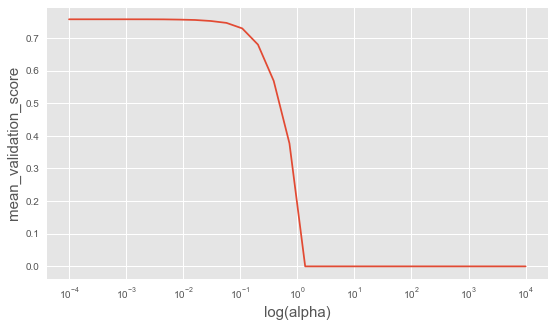

In [121]:
print("Lasso Grid Search")
lasso_grid_est = build_grid_search_est(Lasso(), X_train_std, y_train, cv=kfold,
                                       alpha=np.logspace(-4, 4, 30))

print("Lasso Best Score:", lasso_grid_est.best_score_)

Ridge Grid Search


/Users/sakina/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/sakina/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Ridge Best Score: 0.757280045451


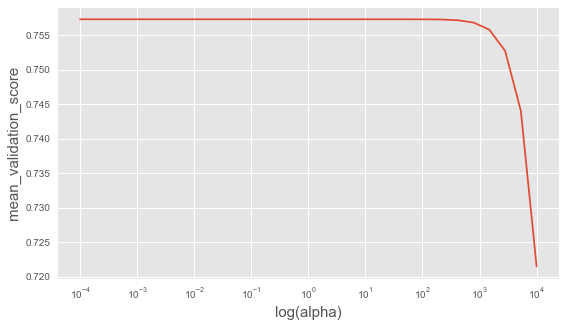

In [122]:
print("Ridge Grid Search")
ridge_grid_est = build_grid_search_est(Ridge(), X_train_std, y_train, cv=kfold,
                                       alpha=np.logspace(-4, 4, 30))

print("Ridge Best Score:", ridge_grid_est.best_score_)

**Final model: Model 6 which predicts log pledged amount using log goal amount, duration of campaign, log of number of rewards, and category of project**

# Applying Model 6 on holdout set

In [135]:
feature_col = ['category', 'goal_log', 'duration', 'rewards_log', 'project_status']
target_col = ['pledged_log']

project_test_df = X_holdout_all[feature_col].join(y_holdout_all[target_col])
(project_test_df.columns, project_test_df.shape)

(Index(['category', 'goal_log', 'duration', 'rewards_log', 'project_status',
        'pledged_log'],
       dtype='object'), (7049, 6))

In [136]:
success_idx = project_test_df.index[project_test_df['project_status']=='successful']
failed_idx = project_test_df.index[project_test_df['project_status']=='failed']
(len(success_idx), len(failed_idx))

(6521, 528)

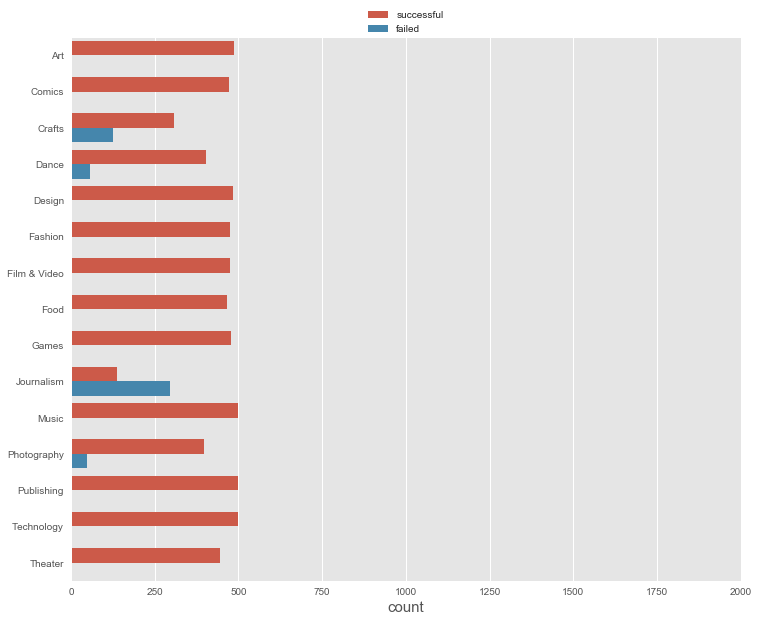

In [137]:
fig = plt.figure(figsize=(12,10));
sns.countplot(y='category',hue='project_status', data=project_test_df, 
              order = project_test_df['category'].sort_values().unique());
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.065));
plt.ylabel('');
plt.xlim([0, 2000]);
fig.savefig('TestPortfolio.png', bbox_inches='tight');

In [138]:
project_test_df.drop(['project_status'], inplace=True, axis=1)

In [139]:
category_dummy = pd.get_dummies(project_test_df['category'])
project_test_df = project_test_df.join(category_dummy)
project_test_df.drop(['category', 'Theater'], inplace=True, axis=1)
# we want to get rid of one dummy variable to avoid the dummy variable trap

In [140]:
X_holdout, y_holdout  = project_test_df.drop('pledged_log',axis=1), project_test_df['pledged_log']
(X_holdout.shape, X_holdout.columns, len(y_holdout))

((7049, 17),
 Index(['goal_log', 'duration', 'rewards_log', 'Art', 'Comics', 'Crafts',
        'Dance', 'Design', 'Fashion', 'Film & Video', 'Food', 'Games',
        'Journalism', 'Music', 'Photography', 'Publishing', 'Technology'],
       dtype='object'),
 7049)

In [141]:
# Standardize the test feature set
X_test_std = StandardScaler().fit_transform(X_holdout)

y_test_pred = lr_loglog_model.predict(X_test_std)
print('R2: %.4f\nRMSE: %.4f' %(r2_score(y_holdout, y_test_pred), RMSE(y_holdout, y_test_pred)))

R2: 0.7466
RMSE: 0.9778


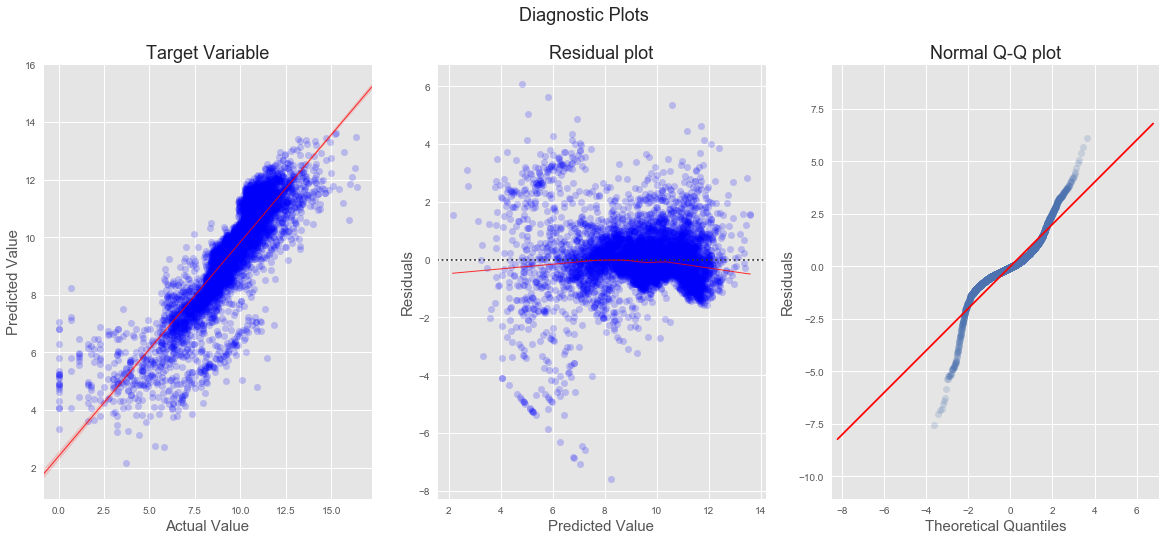

In [142]:
fig = diagnostic_plot(X_test_std, y_holdout, lr_loglog_model);
fig.savefig('DiagnosticPlotTestSet.png', bbox_inches='tight');

In [ ]:
X_test_success = X_holdout.loc[success_idx]
X_test_fail = X_holdout.loc[failed_idx]
y_test_success = y_holdout.loc[success_idx]
y_test_fail = y_holdout.loc[failed_idx]

In [ ]:
# test on success projects
# Standardize the test feature set
X_test_std_success = StandardScaler().fit_transform(X_test_success)

y_test_pred_success = lr_loglog_model.predict(X_test_std_success)
print('Successful projects --- R2: %.4f\nRMSE: %.4f' %(r2_score(y_test_success, y_test_pred_success), 
                               RMSE(y_test_success, y_test_pred_success)))

In [ ]:
# test on failed projects
# Standardize the test feature set
X_test_std_fail = StandardScaler().fit_transform(X_test_fail)

y_test_pred_fail = lr_loglog_model.predict(X_test_std_fail)
print('Failed projects --- R2: %.4f\nRMSE: %.4f' %(r2_score(y_test_fail, y_test_pred_fail), 
                               RMSE(y_test_fail, y_test_pred_fail)))